In [1]:
import os
import xarray as xr
import numpy as np
import pickle
from tqdm import tqdm

def process_and_save_individual_hurricanes(folder_path, output_folder='hurricane_cache'):
    """
    Process each hurricane file separately and save individual results.
    """
    nc_files = [f for f in os.listdir(folder_path) if f.endswith('.nc')]
    print(f"Found {len(nc_files)} hurricane datasets")
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    for nc_file in tqdm(nc_files, desc="Processing hurricanes"):
        try:
            ds = xr.open_dataset(os.path.join(folder_path, nc_file))
            results = {}
            
            # Calculate w10 if components exist
            if 'u10' in ds and 'v10' in ds:
                u10 = ds['u10'].values
                v10 = ds['v10'].values
                results['w10'] = np.sqrt(u10**2 + v10**2).flatten()
            else:
                print(f"Warning: u10/v10 not found in {nc_file}")
                results['w10'] = np.array([])
            
            # Get tp if exists
            if 'tp' in ds:
                results['tp'] = ds['tp'].values.flatten()
            else:
                print(f"Warning: tp not found in {nc_file}")
                results['tp'] = np.array([])
            
            # Add hurricane info
            parts = nc_file.split('_')
            results['hurricane_id'] = f"{parts[0]}_{parts[1]}_{parts[2]}"
            
            # Save individual hurricane data
            output_file = os.path.join(output_folder, f"{results['hurricane_id']}.pkl")
            with open(output_file, 'wb') as f:
                pickle.dump(results, f)
            
            ds.close()
            
        except Exception as e:
            print(f"Error processing {nc_file}: {str(e)}")
            continue

if __name__ == "__main__":
    data_folder = "/Users/jyx/M4R/data_nc_combined"
    process_and_save_individual_hurricanes(data_folder)

Found 81 hurricane datasets


Processing hurricanes: 100%|██████████| 81/81 [00:02<00:00, 32.58it/s]


In [ ]:
import os
import xarray as xr
import numpy as np

# Initialize empty lists to store chunks of data
tp_chunks = []
w10_chunks = []

folder_path = "/Users/jyx/M4R/data_nc_combined"
nc_files = [f for f in os.listdir(folder_path) if f.endswith('.nc')]

for nc_file in nc_files:
    # Open the file 
    ds = xr.open_dataset(os.path.join(folder_path, nc_file))
    
    # Process tp if exists
    if 'tp' in ds:
        tp_chunks.append(ds['tp'].values.flatten())  # Flatten to 1D array
    
    # Process w10 (wind speed) if components exist
    if 'u10' in ds and 'v10' in ds:
        w10 = np.sqrt(ds['u10']**2 + ds['v10']**2).values.flatten()
        w10_chunks.append(w10)
    
    ds.close()  # Free memory immediately
    
# Concatenate all chunks into arrays
tp_array = np.concatenate(tp_chunks)
w10_array = np.concatenate(w10_chunks)

# Filter invalid values
valid_mask = np.isfinite(tp_array) & np.isfinite(w10_array) & (tp_array >= 0) & (w10_array >= 0)
tp_array = tp_array[valid_mask]
w10_array = w10_array[valid_mask]

Filtered to 1445164 extreme events (top 2.2%)


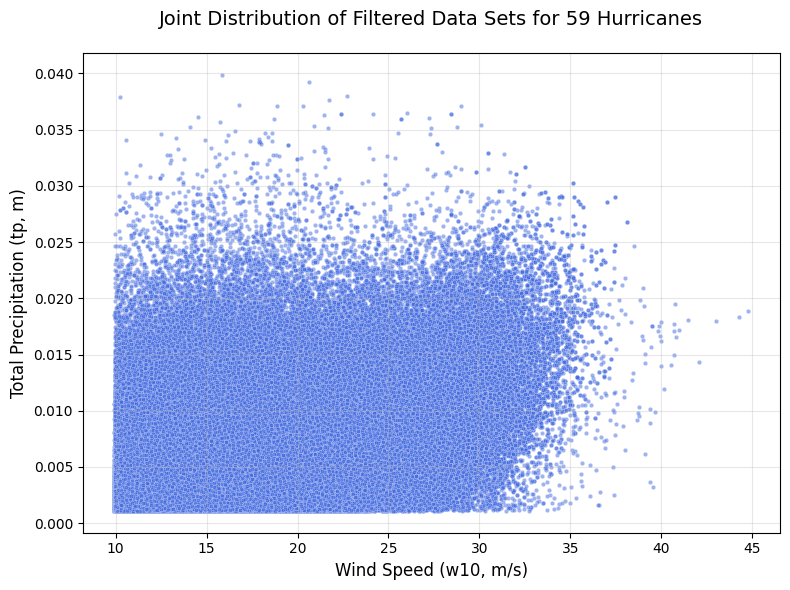

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate thresholds 
tp_threshold = np.quantile(tp_array, 0.92)
w10_threshold = np.quantile(w10_array, 0.89)

# Filter the arrays
filter_mask = (tp_array >= tp_threshold) & (w10_array >= w10_threshold)
w10_filtered = w10_array[filter_mask]
tp_filtered = tp_array[filter_mask]

print(f"Filtered to {len(w10_filtered)} extreme events (top {len(w10_filtered)/len(w10_array)*100:.1f}%)")

# Create the filtered joint distribution plot (standalone version)
plt.figure(figsize=(8, 6))  

sns.scatterplot(
    x=w10_filtered, 
    y=tp_filtered, 
    alpha=0.5, 
    s=10,
    color='royalblue'
)
plt.xlabel('Wind Speed (w10, m/s)', fontsize=12)
plt.ylabel('Total Precipitation (tp, m)', fontsize=12)
plt.title(
    #f'Extreme Events: w10 ≥ {w10_threshold:.1f} m/s, tp ≥ {tp_threshold:.3f} m',
    f'Joint Distribution of Filtered Data Sets for 59 Hurricanes',
    fontsize=14,
    pad=20
)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Filtered to 1445164 extreme events (~2.2% of total)


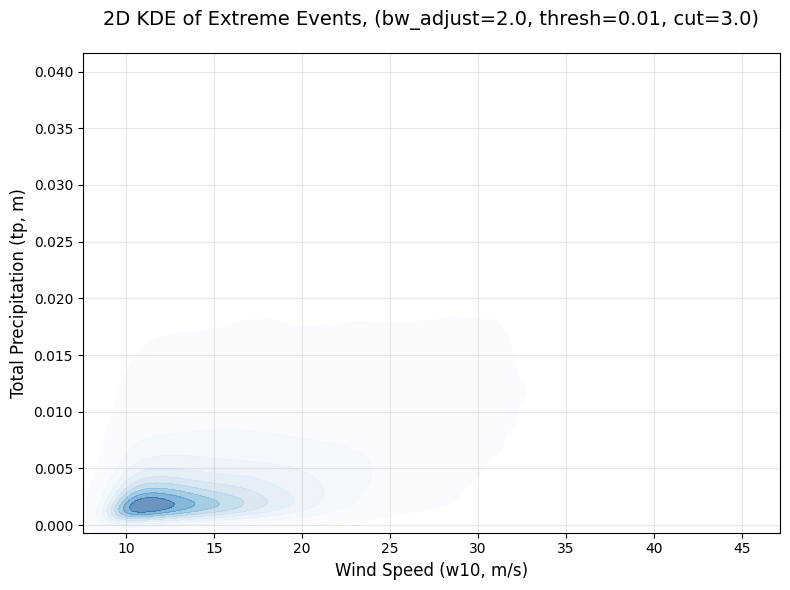

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Compute the thresholds
tp_threshold = np.quantile(tp_array, 0.92)   
w10_threshold = np.quantile(w10_array, 0.89) 

# Filter to extreme events
mask = (tp_array >= tp_threshold) & (w10_array >= w10_threshold)
w10_filtered = w10_array[mask]
tp_filtered = tp_array[mask]

n_extreme = len(w10_filtered)
pct_extreme = 100 * n_extreme / len(w10_array)
print(f"Filtered to {n_extreme} extreme events (~{pct_extreme:.1f}% of total)")

# 2D KDE with explicit parameters
plt.figure(figsize=(8, 6))

sns.kdeplot(
    x=w10_filtered,
    y=tp_filtered,
    cmap="Blues",
    fill=True,
    levels=10,
    thresh=0.01,        # include density down to 1% of the peak
    bw_adjust=2.0,      # ↑ the critical “bandwidth” multiplier
    cut=3.0,            # extend KDE grid 3×bandwidth beyond data range
    alpha=0.6,
)

plt.xlabel('Wind Speed (w10, m/s)', fontsize=12)
plt.ylabel('Total Precipitation (tp, m)', fontsize=12)

plt.title(
    f"2D KDE of Extreme Events, "
    f"(bw_adjust=2.0, thresh=0.01, cut=3.0)",
    fontsize=14,
    pad=20
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



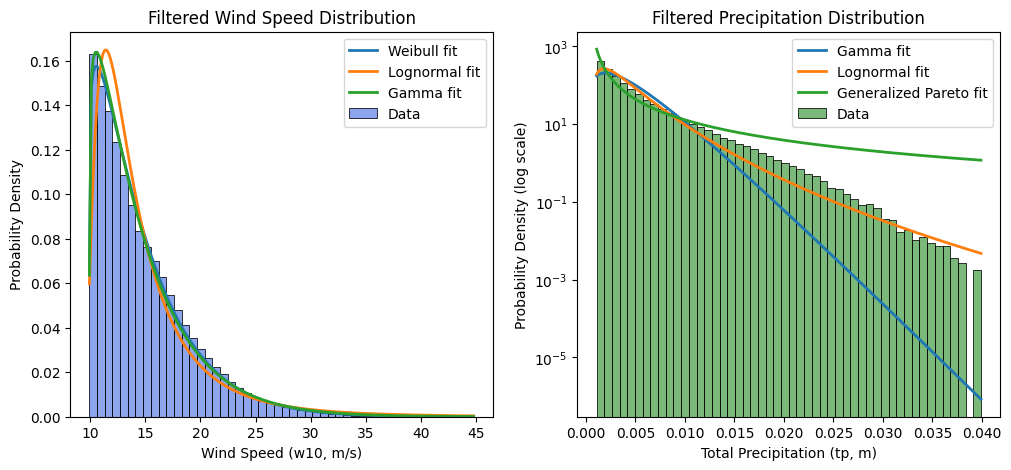

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_filtered_distributions(w10_filtered, tp_filtered):
    """
    Plot individual distributions with fitted probability density functions.
    
    Args:
        w10_filtered (array): Filtered wind speed data
        tp_filtered (array): Filtered precipitation data
    """
    plt.figure(figsize=(12, 5))
    
    # ------------------------------------------
    # Wind Speed (w10) Distribution
    # ------------------------------------------
    plt.subplot(1, 2, 1)
    
    # Histogram
    sns.histplot(w10_filtered, bins=50, kde=False, stat='density', 
                color='royalblue', alpha=0.6, label='Data')
    
    # Fit distributions
    dists = {
        'Weibull': stats.weibull_min,
        'Lognormal': stats.lognorm,
        'Gamma': stats.gamma
    }
    
    x = np.linspace(w10_filtered.min(), w10_filtered.max(), 200)
    
    for name, dist in dists.items():
        try:
            params = dist.fit(w10_filtered)
            pdf = dist.pdf(x, *params)
            plt.plot(x, pdf, lw=2, label=f'{name} fit')
        except:
            continue
    
    plt.xlabel('Wind Speed (w10, m/s)')
    plt.ylabel('Probability Density')
    plt.title('Filtered Wind Speed Distribution')
    plt.legend()
    
    # ------------------------------------------
    # Precipitation (tp) Distribution
    # ------------------------------------------
    plt.subplot(1, 2, 2)
    
    # Histogram (log scale for y-axis)
    sns.histplot(tp_filtered, bins=50, kde=False, stat='density',
                 color='forestgreen', alpha=0.6, label='Data')
    plt.yscale('log')  # Emphasize tail

    x_tp = np.linspace(tp_filtered.min(), tp_filtered.max(), 300)

    # Fix loc=0 or threshold if known (e.g., 94th percentile threshold)
    gamma_params = stats.gamma.fit(tp_filtered, floc=0)
    gamma_pdf = stats.gamma.pdf(x_tp, *gamma_params)
    plt.plot(x_tp, gamma_pdf, lw=2, label='Gamma fit')

    lognorm_params = stats.lognorm.fit(tp_filtered, floc=0)
    lognorm_pdf = stats.lognorm.pdf(x_tp, *lognorm_params)
    plt.plot(x_tp, lognorm_pdf, lw=2, label='Lognormal fit')

    gpd_params = stats.genpareto.fit(tp_filtered)
    gpd_pdf = stats.genpareto.pdf(x_tp, *gpd_params)
    plt.plot(x_tp, gpd_pdf, lw=2, label='Generalized Pareto fit')
    

    plt.xlabel('Total Precipitation (tp, m)')
    plt.ylabel('Probability Density (log scale)')
    plt.title('Filtered Precipitation Distribution')
    plt.legend()


# Usage
if __name__ == "__main__":
    # Convert to numpy arrays if they aren't already
    w10_filtered = np.array(w10_filtered)
    tp_filtered = np.array(tp_filtered)
    
    plot_filtered_distributions(w10_filtered, tp_filtered)